# Journal Analysis

In [1]:
import pandas as pd
import seaborn as sns
import sqlitedict
from matplotlib import pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import requests

In [2]:
metadata = sqlitedict.SqliteDict('../synth/data/doi_metadata.db')
journal_list = []
for k, v in metadata.items():
    issns = v.get('issn-type', [])
    if len(issns) == 0:
        continue
    try:
        issn = next(i for i in issns if i['type'] == 'print')['value']
    except StopIteration:
        issn = issns[0]['value']
    journal_list.append({'ISSN': issn.replace('-', ''), 'Count': 1})

journal_list_df = pd.DataFrame(journal_list).groupby(['ISSN']).sum().reset_index()

journal_list_df

,ISSN,Count
0,00015709,1
1,00017051,1
2,00017272,6
3,00027014,1
4,00028444,1
...,...,...
594,23850442,1
595,23915412,1
596,2405853X,1
597,25314033,1


Load the 2019 CiteScore data downloaded from https://www.scopus.com/sources.

In [3]:
scopus = pd.read_csv('scopus-citescore.csv', delimiter='\t')

# we don't need every column
scopus = scopus.loc[:,['Open Access', 'CiteScore', 'Print ISSN', 'E-ISSN', 'Scopus ASJC Code (Sub-subject Area)']]

# rename the 'Sub-Subject Area' column
scopus['ASJC'] = scopus['Scopus ASJC Code (Sub-subject Area)'].fillna(0).astype(int)
scopus = scopus.drop('Scopus ASJC Code (Sub-subject Area)', axis=1)

# combine the print + electronic ISSNs and split multiple ISSNs into separate rows
scopus['ISSN'] = scopus['Print ISSN'].astype(str) + ' ' + scopus['E-ISSN'].astype(str)
scopus.ISSN = scopus.ISSN.apply(lambda x: [y.strip() for y in x.split(' ')])
scopus = scopus.explode('ISSN').drop('Print ISSN', axis=1).drop('E-ISSN', axis=1)
scopus = scopus[scopus.ISSN != 'nan']

# format the values in the access column
scopus['Open Access'] = scopus['Open Access'].replace('YES', 'Open').replace('NO', 'Not Open')

scopus

,Open Access,CiteScore,ASJC,ISSN
0,Not Open,2.9,3203,13524658
0,Not Open,2.9,3203,14691833
1,Not Open,2.5,1903,991112
2,Not Open,0.9,1500,10008713
2,Not Open,0.9,1500,18722059
...,...,...,...,...
57013,Not Open,0.0,3310,22797149
57014,Not Open,0.0,1208,22797149
57015,Not Open,0.0,1202,22797149
57016,Not Open,0.1,2917,14412551


Scrape the ASJC data from this page: https://service.elsevier.com/app/answers/detail/a_id/15181/supporthub/scopus

In [4]:
response = requests.get('https://service.elsevier.com/app/answers/detail/a_id/15181/supporthub/scopus')
page = BeautifulSoup(response.content)
table_rows = page.find('table').find_all('tr')[1:]
all_asjc = [tuple([cell.text for cell in row.find_all('td')]) for row in table_rows]

asjc_df = pd.DataFrame(all_asjc, columns=['Code', 'Subject', 'Group'])
asjc_df['Code'] = asjc_df.Code.astype(int)
asjc_df

,Code,Subject,Group
0,1000,Multidisciplinary,Multidisciplinary
1,1100,General Agricultural and Biological Sciences,Life Sciences
2,1101,Agricultural and Biological Sciences (miscella...,Life Sciences
3,1102,Agronomy and Crop Science,Life Sciences
4,1103,Animal Science and Zoology,Life Sciences
...,...,...,...
329,3612,"Physical Therapy, Sports Therapy and Rehabilit...",Health Sciences
330,3613,Podiatry,Health Sciences
331,3614,Radiological and Ultrasound Technology,Health Sciences
332,3615,Respiratory Care,Health Sciences


Add the subject data to the scopus dataframe.

In [5]:
scopus = scopus.set_index('ASJC').join(asjc_df.set_index('Code')).reset_index(drop=True)
scopus

,Open Access,CiteScore,ISSN,Subject,Group
0,Not Open,1.1,23791381,NaN,NaN
1,Not Open,1.1,2379139X,NaN,NaN
2,Not Open,1.0,26399636,NaN,NaN
3,Not Open,1.0,26399644,NaN,NaN
4,Not Open,0.2,23748265,NaN,NaN
...,...,...,...,...,...
90967,Not Open,1.9,10989056,Speech and Hearing,Health Sciences
90968,Not Open,3.0,17483107,Speech and Hearing,Health Sciences
90969,Not Open,3.0,17483115,Speech and Hearing,Health Sciences
90970,Not Open,3.4,14992027,Speech and Hearing,Health Sciences


Load the 2019 Scimago Journal Rank data downloaded from https://www.scimagojr.com/journalrank.php.

In [6]:
sjr = pd.read_csv('scimagojr 2019.csv', delimiter=';')

# we don't need every column
sjr = sjr.loc[:, ['Issn', 'Rank', 'SJR', 'H index', 'Region', 'Publisher']]

# split multiple ISSNs into separate rows
sjr.Issn = sjr.Issn.apply(lambda x: [y.strip() for y in x.split(',')])
sjr = sjr.explode('Issn')

# reformat the SJR values as floats
sjr.SJR = sjr.SJR.apply(lambda x: str(x).replace(',', '.')).astype(float)

Join the three dataframes together. Note that there are duplicates in the resulting dataframe, due to multiple rows for the same ISSN in the scopus dataset. This will be accounted for before displaying the data graphically.

In [7]:
df = journal_list_df.set_index('ISSN').join(scopus.set_index('ISSN'), how='left', rsuffix='scopus')
df = df.join(sjr.set_index('Issn'), how='left', rsuffix='sjr')
df = df.drop_duplicates()
df

,Count,Open Access,CiteScore,Subject,Group,Rank,SJR,H index,Region,Publisher
00015709,1,NaN,NaN,NaN,NaN,9227.0,0.535,34.0,Eastern Europe,"Polish Academy of Sciences, Committee of Geolo..."
00017051,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00017272,6,NaN,NaN,NaN,NaN,10841.0,0.445,36.0,Western Europe,Wiley-Blackwell Publishing Ltd
00027014,1,NaN,NaN,NaN,NaN,9447.0,0.520,37.0,Latin America,Asociacion Paleontologica Argentina
00028444,1,NaN,NaN,NaN,NaN,17608.0,0.217,26.0,Northern America,American Fern Society
...,...,...,...,...,...,...,...,...,...,...
23915412,1,Open,1.1,"General Biochemistry, Genetics and Molecular B...",Life Sciences,18303.0,0.204,30.0,Western Europe,Walter de Gruyter GmbH
23915412,1,Open,1.1,General Immunology and Microbiology,Life Sciences,18303.0,0.204,30.0,Western Europe,Walter de Gruyter GmbH
23915412,1,Open,1.1,General Neuroscience,Life Sciences,18303.0,0.204,30.0,Western Europe,Walter de Gruyter GmbH
25314033,1,Open,2.3,"Ecology, Evolution, Behavior and Systematics",Life Sciences,11022.0,0.437,15.0,Eastern Europe,Pensoft Publishers


Some journals are not found in either the CiteScore or SJR database.

In [8]:
df[df.CiteScore.isna() & df.SJR.isna() & df['H index'].isna()].sort_values(['Count'], ascending=False)

,Count,Open Access,CiteScore,Subject,Group,Rank,SJR,H index,Region,Publisher
20844352,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18759866,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13142836,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00180971,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00786594,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00075167,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00017051,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Define a function to display a specific metric and facet.

In [9]:
sns.set_theme(style='darkgrid')
from textwrap import wrap

def visualise(metric, facet, title, start_df=None):
    if start_df is None:
        start_df = df
    graph_df = df.loc[:, [metric, facet, 'Count']].drop_duplicates()
    metric_summary = graph_df.groupby([metric]).sum().reset_index()
    metric_summary[facet] = pd.Series(['Total'] * metric_summary.shape[0])
    graph_df = pd.concat([graph_df, metric_summary]).replace(0, np.NaN).dropna()
    
    w = max(len(graph_df[facet].unique()), 8)
    h = 10
    
    fig, ax = plt.subplots(figsize=(w, h))
    sns.stripplot(data=graph_df, x=facet, y=metric, hue=facet, size=5, alpha=0.5, palette='Set2')
    ax.legend().remove()
    
    x_labels = ['\n'.join(wrap(l.get_text(), 10)) for l in ax.get_xticklabels()]
    
    plt.xticks(rotation=90, ticks=list(range(len(x_labels))), labels=x_labels)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    sns.despine()
    plt.show()

# Open Access Status

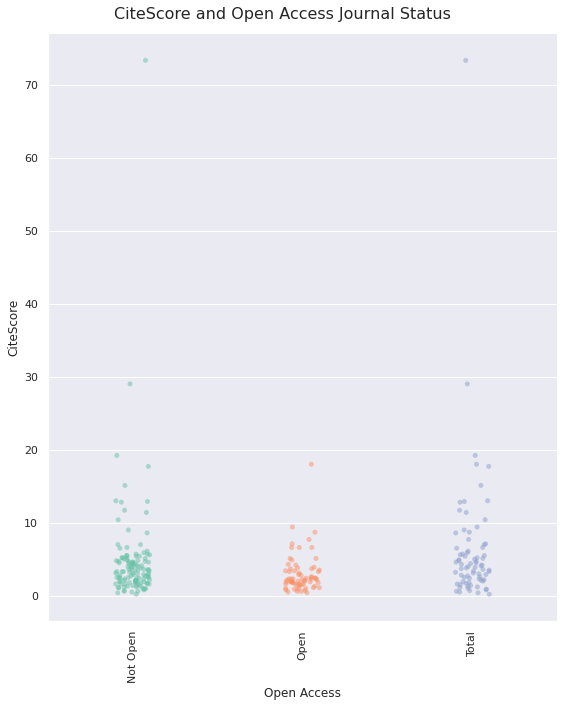

In [10]:
visualise('CiteScore', 'Open Access', 'CiteScore and Open Access Journal Status')

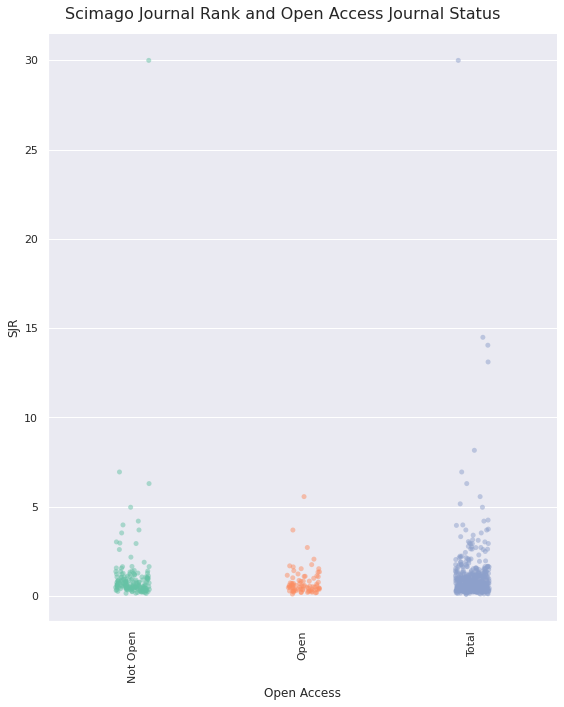

In [11]:
visualise('SJR', 'Open Access', 'Scimago Journal Rank and Open Access Journal Status')

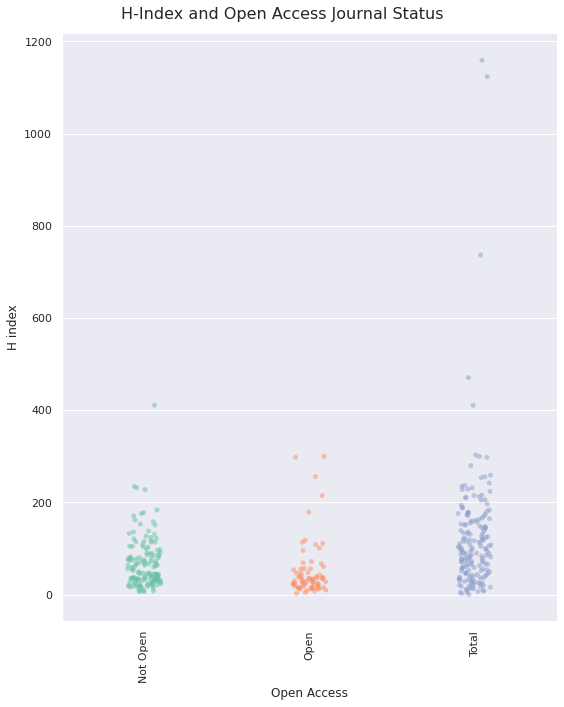

In [12]:
visualise('H index', 'Open Access', 'H-Index and Open Access Journal Status')

# Journal Publishing Region

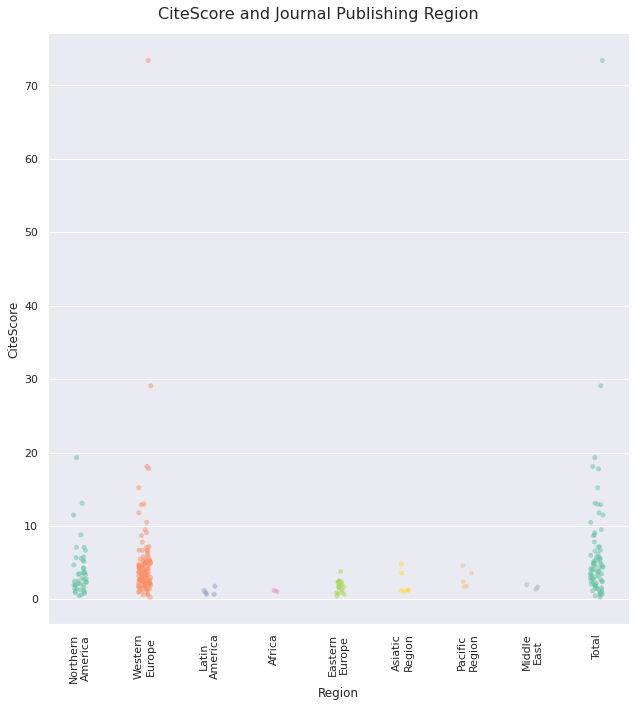

In [13]:
visualise('CiteScore', 'Region', 'CiteScore and Journal Publishing Region')

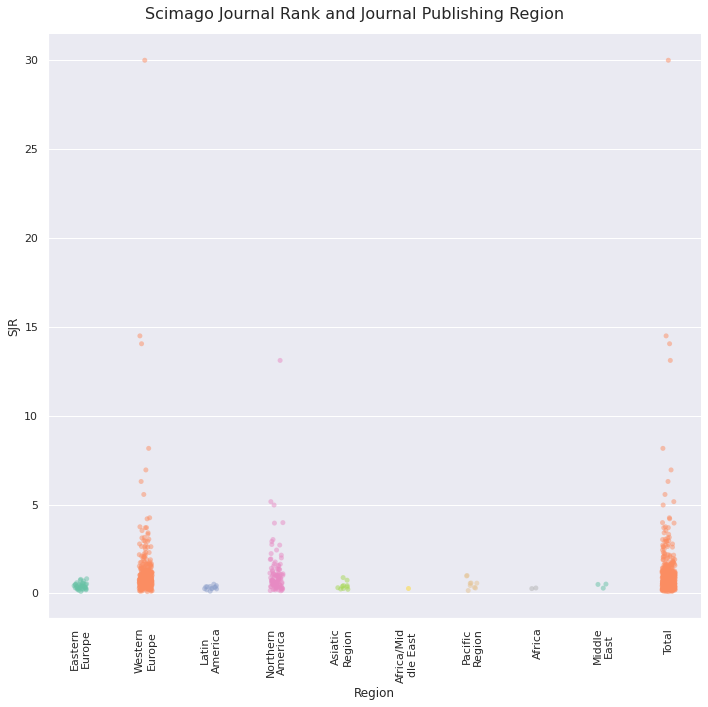

In [14]:
visualise('SJR', 'Region', 'Scimago Journal Rank and Journal Publishing Region')

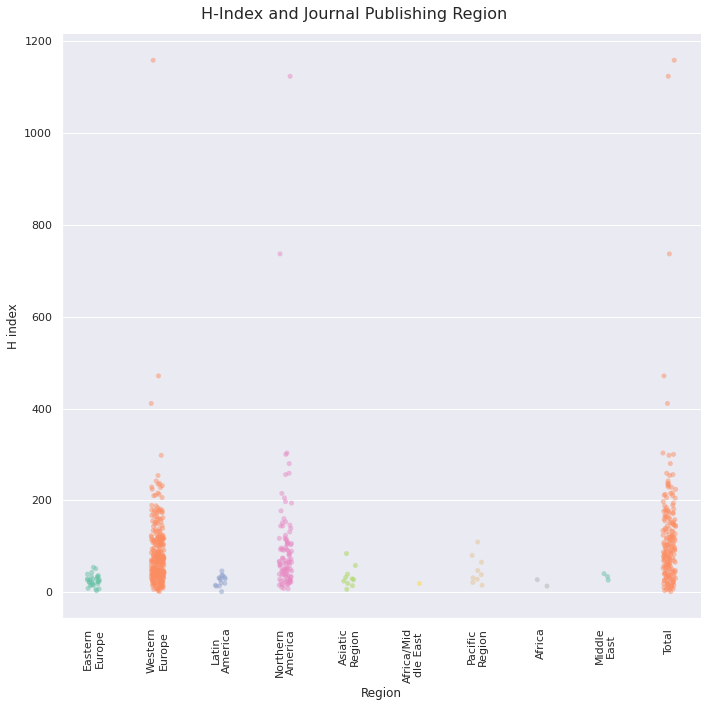

In [15]:
visualise('H index', 'Region', 'H-Index and Journal Publishing Region')

# Topic

In [16]:
topic_df = df.loc[:, ['CiteScore', 'SJR', 'H index', 'Group', 'Count']].dropna(subset=['Group']).drop_duplicates()

topic_df

,CiteScore,SJR,H index,Group,Count
0003004X,5.3,1.573,131.0,Physical Sciences,5
0006324X,1.2,0.362,28.0,Life Sciences,1
0007196X,1.4,0.384,27.0,Life Sciences,1
0008347X,2.2,0.473,40.0,Life Sciences,3
0010065X,0.8,0.344,22.0,Life Sciences,3
...,...,...,...,...,...
2352409X,2.9,0.791,21.0,Social Sciences & Humanities,1
2353074X,0.8,0.217,3.0,Life Sciences,1
23818107,2.2,0.385,18.0,Life Sciences,2
23915412,1.1,0.204,30.0,Life Sciences,1


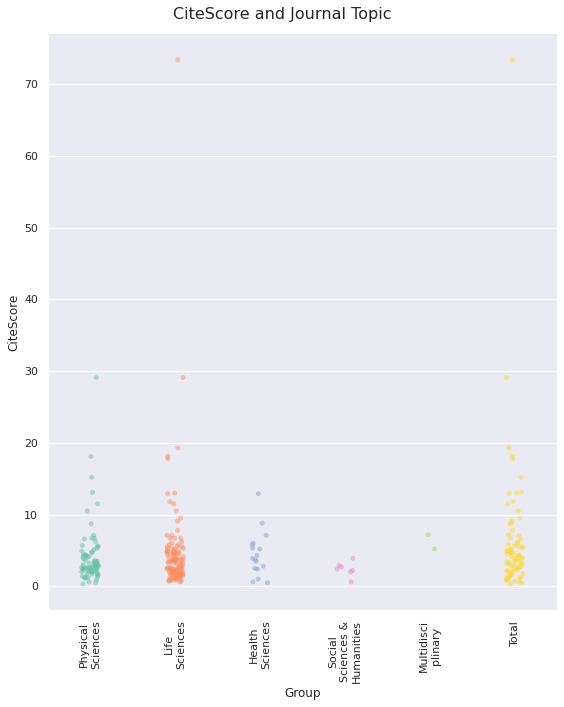

In [17]:
visualise('CiteScore', 'Group', 'CiteScore and Journal Topic', topic_df)

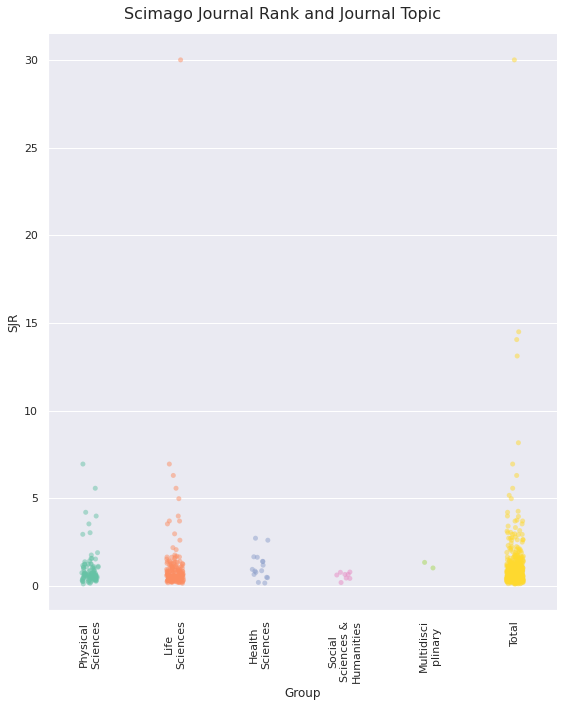

In [18]:
visualise('SJR', 'Group', 'Scimago Journal Rank and Journal Topic', topic_df)

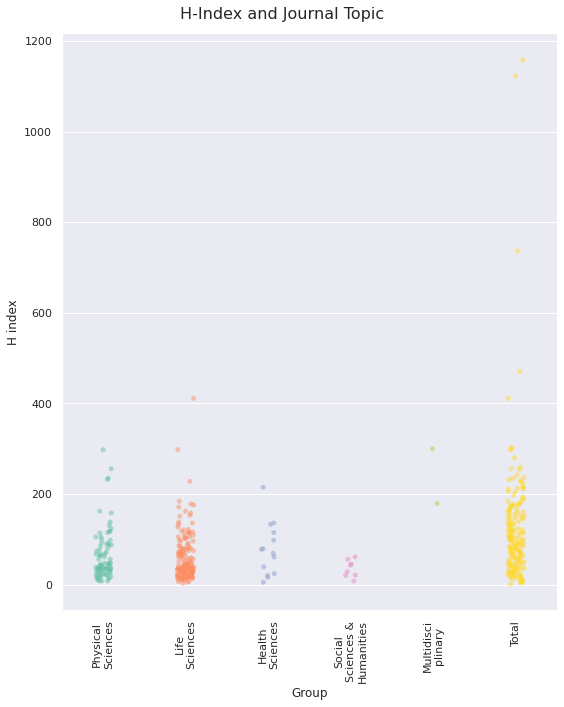

In [19]:
visualise('H index', 'Group', 'H-Index and Journal Topic', topic_df)